In [0]:
# # https://keras.io/
# !pip install -q keras
# import keras

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, Activation,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
import tensorflow.keras.backend as K

In [0]:
#Copied code from https://raw.githubusercontent.com/bckenstler/CLR/master/clr_callback.py
from tensorflow.keras.callbacks import *
class CyclicLR(Callback):

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())


In [0]:
# # this part will prevent tensorflow to allocate all the avaliable GPU Memory
# # backend
# import tensorflow as tf
# from keras import backend as k

# # Don't pre-allocate memory; allocate as-needed
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

# # Create a session with the above options specified.
# k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 250
l = 16
num_filter = 32
growth_rate = 12
compression = 0.5
dropout_rate = 0.2
weight_decay = 1e-4
dilate_rate = 1


In [0]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

for i in range(3):
		mean = np.mean(x_train[:, :, :, i])
		std = np.std(x_train[:, :, :, i])
		x_train[:, :, :, i] = (x_train[:, :, :, i] - mean) / std
		x_test[:, :, :, i] = (x_test[:, :, :, i] - mean) / std

In [0]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression, weight_decay, growth_rate

    temp = input
    #concat_layers = [input]
    for _ in range(l):
      
        BatchNorm = BatchNormalization(gamma_regularizer=l2(weight_decay),beta_regularizer=l2(weight_decay))(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_1_1 = Conv2D(int(growth_rate*4), (1,1), use_bias=False ,padding='same',
                              kernel_initializer='he_uniform',kernel_regularizer=l2(weight_decay))(relu)
        
        BatchNorm_1_1 = BatchNormalization(gamma_regularizer=l2(weight_decay),beta_regularizer=l2(weight_decay))(Conv2D_1_1)
        relu_1_1 = Activation('relu')(BatchNorm_1_1)
        Conv2D_3_3 = Conv2D(int(growth_rate), (3,3), use_bias=False ,padding='same', dilation_rate = dilate_rate,
                              kernel_initializer='he_uniform',kernel_regularizer=l2(weight_decay))(relu_1_1)
        
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(rate=dropout_rate)(Conv2D_3_3)
        #concat_layers.append(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        num_filter += growth_rate
        
    return temp , num_filter

In [0]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression, weight_decay
    BatchNorm = BatchNormalization(gamma_regularizer=l2(weight_decay),beta_regularizer=l2(weight_decay))(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same',
                              kernel_initializer='he_uniform',kernel_regularizer=l2(weight_decay))(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(rate=dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2),strides=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    global compression, weight_decay
    BatchNorm = BatchNormalization(gamma_regularizer=l2(weight_decay),beta_regularizer=l2(weight_decay))(input)
    relu = Activation('relu')(BatchNorm)
    #AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    #flat = Flatten()(AvgPooling)
    #output = Dense(num_classes, activation='softmax')(flat)
    GloAvgPooling = GlobalAveragePooling2D()(relu)
    output = Dense(num_classes, activation='softmax',
		kernel_regularizer=l2(weight_decay),bias_regularizer=l2(weight_decay))(GloAvgPooling)
    
    return output

In [0]:

input = Input(shape=(img_height, img_width, channel))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same', dilation_rate = dilate_rate,
			kernel_initializer='he_uniform',kernel_regularizer=l2(weight_decay))(input)

First_Block, num_filters = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filters, dropout_rate)

Second_Block,num_filters = add_denseblock(First_Transition, num_filters, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filters, dropout_rate)

# Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
# Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block,num_filters = add_denseblock(Second_Transition,  num_filters, dropout_rate)
output = output_layer(Last_Block)


In [11]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [0]:
datagen = ImageDataGenerator(
			featurewise_center=False,  # set input mean to 0 over the dataset
			samplewise_center=False,  # set each sample mean to 0
			featurewise_std_normalization=False,  # divide inputs by std of the dataset
			samplewise_std_normalization=False,  # divide each input by its std
			zca_whitening=False,  # apply ZCA whitening
			rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
			width_shift_range=0.16,  # randomly shift images horizontally (fraction of total width)
			height_shift_range=0.16,  # randomly shift images vertically (fraction of total height)
			horizontal_flip=True,  # randomly flip images
			vertical_flip=False) # randomly flip images
       

In [0]:
def step_decay(epoch):
	initial_lrate = 0.1
	lrate = 0.1
	if epoch >= 125 and epoch < 187:
		lrate = initial_lrate / 10
	if epoch >= 187 :
		lrate = initial_lrate / 100
	
	return float(lrate)
lrschedular = LearningRateScheduler(step_decay)

In [0]:
lr_reducer      = ReduceLROnPlateau(monitor='val_acc', factor=np.sqrt(0.1),
                                    cooldown=0, patience=5, min_lr=1e-5)

In [0]:
# !rm -rf clr_callback.py*
# !wget https://github.com/bckenstler/CLR/raw/master/clr_callback.py
# from clr_callback import *

clr_triangular = CyclicLR(mode='triangular',base_lr=0.001, max_lr=0.1, step_size=782*8)

In [0]:
# determine Loss function and Optimizer
# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(),
#               metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),#momentum=0.9,nesterov=True),
              metrics=['accuracy'])

In [17]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,
                                              strategy = tf.contrib.tpu.TPUDistributionStrategy(
                                                  tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://'+os.environ['COLAB_TPU_ADDR'])
                                              )
                                             )

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.0.210.194:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 6347446215774545733)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 13386831080101798575)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 1825349573857696043)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 12543244047257317185)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 3166087646285837528)
INFO:tensorflow:*** Available Device: _Device

In [18]:
# model.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=50,
#                     verbose=1,
#                     validation_data=(x_test, y_test),
#                     callbacks=[clr_triangular])

tpu_model.fit_generator(datagen.flow(x_train, y_train,
									 batch_size=64),
						steps_per_epoch=782,epochs=240,validation_data=(x_test, y_test),verbose=1,callbacks=[clr_triangular])

Epoch 1/240
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(8, 32, 32, 3), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(8, 10), dtype=tf.float32, name='dense_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning SGD {'lr': 0.0010000000474974513, 'momentum': 0.0, 'decay': 0.0, 'nesterov': False}
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.SGD object at 0x7f0071c46ba8> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 118.51566290855408 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.001}
INFO:tensorflow:CPU -> TPU momentum: 0.0 {0.0}
INFO:tensorflow:CPU -> TPU decay: 0.0 {0.0}
220/782 [=======>......................] - ETA: 12:37 - loss: 4.2641 - acc: 0.1475INFO:tensorflow:N

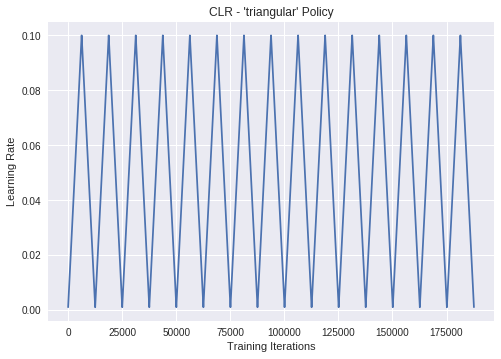

In [19]:
#%%matplotlibmatplotl  inline
import matplotlib.pyplot as plt

plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [20]:
# Test the model
score = tpu_model.evaluate(x_test, y_test, verbose=1)
print(score)
print('Test loss: %.3f ' % (score[0]))
print('Test accuracy: %.3f ' % (score[1]*100))

INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(4, 32, 32, 3), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(4, 10), dtype=tf.float32, name='dense_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.SGD object at 0x7f0036e4b0b8> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 45.530253648757935 secs
10000/10000 [==============================] - 74s 7ms/step
[0.4677452404499054, 0.9329]
Test loss: 0.468 
Test accuracy: 93.290 


In [0]:
# Save the trained weights in to .h5 format
tpu_model.save_weights("DNST_weights_Shravan_B9_1M.h5")
tpu_model.save("DNST_model_Shravan_B9_1M.hdf5")
print("Saved model to disk")

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 0.0010000000474974513
INFO:tensorflow:TPU -> CPU momentum: 0.0
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU nesterov: False
